<a href="https://colab.research.google.com/github/skumbham/PPE-Detection-Using-Yolo11/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Required Installations apart from what already present in Colab

!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 22.5 MB/s eta 0:00:00


In [ ]:
# Keeping the Code Clean

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import the Dataset from Roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="zBx9nLSC08D5wkJpQVQW")
project = rf.workspace("roboflow-universe-projects").project("construction-site-safety")
version = project.version(28)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Construction-Site-Safety-28 in yolov11:: 100%|██████████| 5614/5614 [00:01<00:00, 3412.06it/s]


# **EDA**



In [ ]:
import yaml
import os

# Load the YAML file
yaml_path = 'Construction-Site-Safety-28/data.yaml'
with open(yaml_path, 'r') as file:
  data = yaml.safe_load(file)

# Extract class names
class_names = data['names']

# Paths to the directories containing the YOLO annotations
train_annotations_path = 'Construction-Site-Safety-28/train/labels'
val_annotations_path = 'Construction-Site-Safety-28/valid/labels'
test_annotations_path = 'Construction-Site-Safety-28/test/labels'

# Define paths to the image directories
base_path = 'Construction-Site-Safety-28'
train_images_path = os.path.join(base_path, 'train/images')
val_images_path = os.path.join(base_path, 'valid/images')
test_images_path = os.path.join(base_path, 'test/images')

In [ ]:
# Count of Images
def count_images(images_path):
  return len([f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

train_count = count_images(train_images_path)
val_count = count_images(val_images_path)
test_count = count_images(test_images_path)
total_count = train_count + val_count + test_count

print(f"Total number of images: {total_count}")
print(f"Number of training images: {train_count}")
print(f"Number of validation images: {val_count}")
print(f"Number of test images: {test_count}")

Total number of images: 2801
Number of training images: 2605
Number of validation images: 114
Number of test images: 82


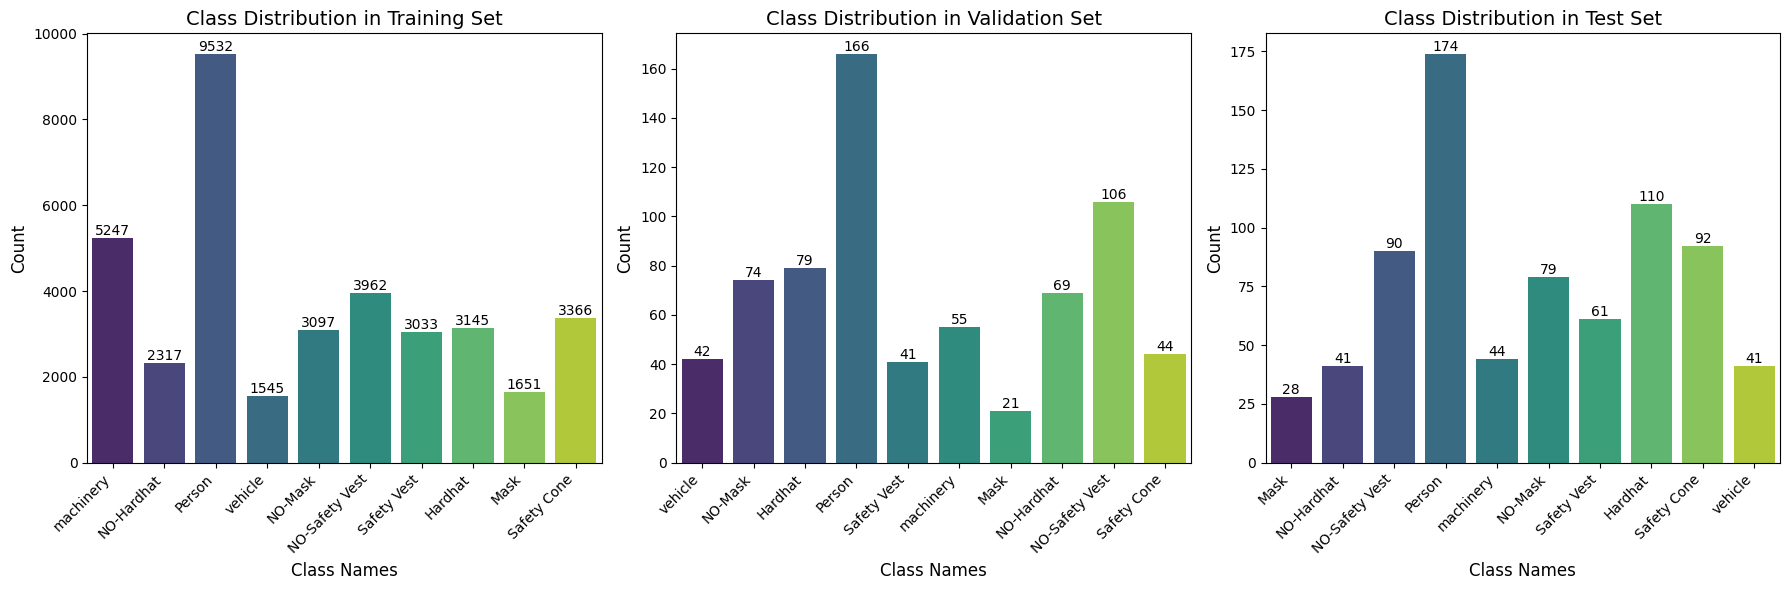

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Function to count the classes in the YOLO annotation files
def count_classes(annotations_path, class_names):
    class_counter = Counter()

    for label_file in os.listdir(annotations_path):
        if label_file.endswith('.txt'):
            file_path = os.path.join(annotations_path, label_file)
            with open(file_path, 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])
                    class_counter[class_names[class_id]] += 1

    return class_counter

# Function to handle subplots
def plot_class_distribution_subplot(ax, class_counts, dataset_type):
    bars = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis", ax=ax)
    ax.set_title(f'Class Distribution in {dataset_type} Set', fontsize=14)
    ax.set_xlabel('Class Names', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Annotate bars with the actual count values
    for bar in bars.patches:
        bar_height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, bar_height, f'{int(bar_height)}', ha='center', va='bottom', fontsize=10)

train_class_counts = count_classes(train_annotations_path, class_names)
val_class_counts = count_classes(val_annotations_path, class_names)
test_class_counts = count_classes(test_annotations_path, class_names)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18,6))
plot_class_distribution_subplot(axs[0], train_class_counts, 'Training')
plot_class_distribution_subplot(axs[1], val_class_counts, 'Validation')
plot_class_distribution_subplot(axs[2], test_class_counts, 'Test')

# Adjust layout
plt.tight_layout()
plt.show()


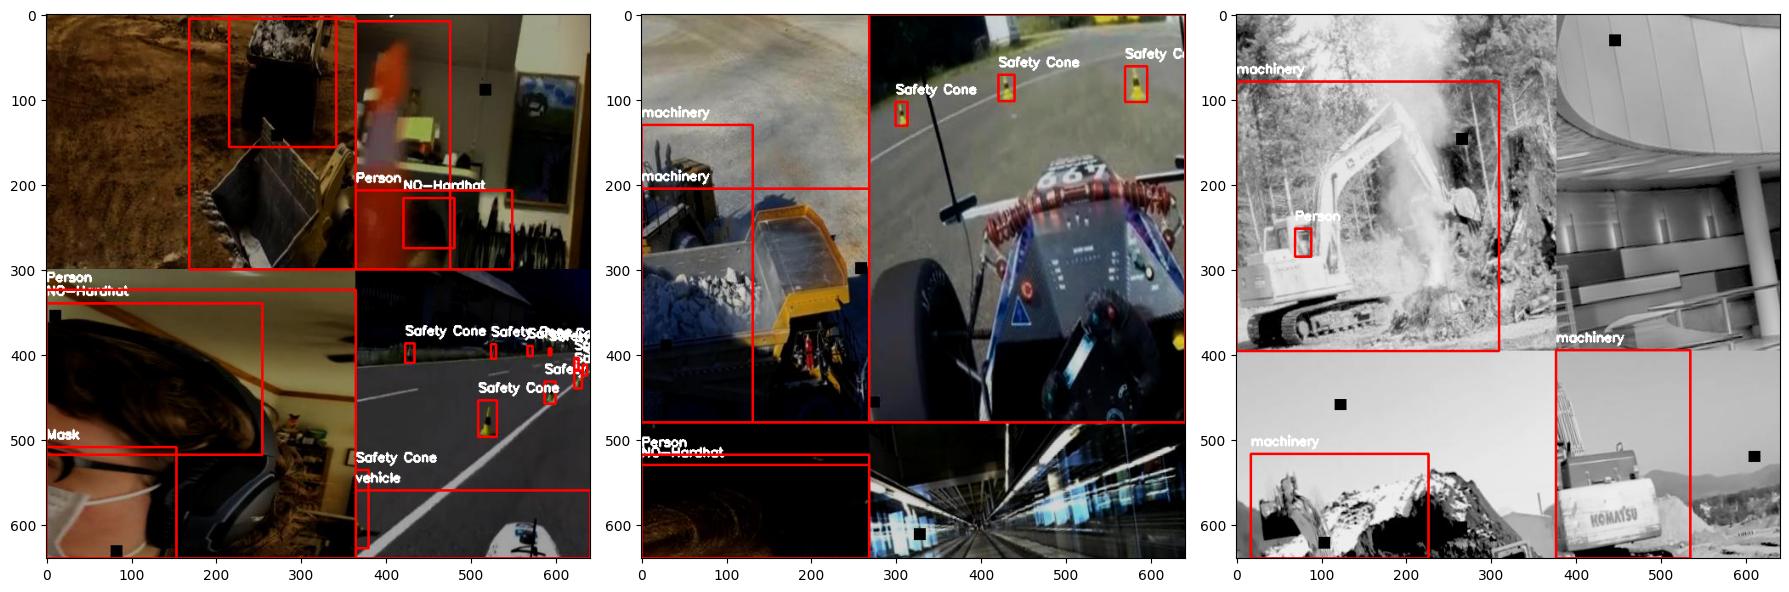

In [ ]:
import cv2
import random

# Display images with bounding boxes and annotated labels from YOLO format
def display_images_with_boxes(images_path, annotations_path, class_names, num_images=3):
    selected_images = random.sample([f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))], num_images)
    fig, axs = plt.subplots(1, num_images, figsize=(18, 6))

    for i, image_file in enumerate(selected_images):
        # Load the image
        image = cv2.cvtColor(cv2.imread(os.path.join(images_path, image_file)), cv2.COLOR_BGR2RGB)

        # Read bounding boxes and draw them
        with open(os.path.join(annotations_path, os.path.splitext(image_file)[0] + '.txt')) as file:
            for line in file:
                class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.split())
                x1, y1 = int((x_center - bbox_width / 2) * image.shape[1]), int((y_center - bbox_height / 2) * image.shape[0])
                x2, y2 = int((x_center + bbox_width / 2) * image.shape[1]), int((y_center + bbox_height / 2) * image.shape[0])
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(image, class_names[int(class_id)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        axs[i].imshow(image)
        axs[i].axis('on')

    plt.tight_layout()
    plt.show()

# Call the function to display three images with bounding boxes and labels
display_images_with_boxes(train_images_path, train_annotations_path, class_names, num_images=3)


In [ ]:
# Import the Pre-Trained Model
from ultralytics import YOLO
model = YOLO("yolo11n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Training the Model
results = model.train(data="/content/Construction-Site-Safety-28/data.yaml", epochs=100, device=0, plots=True)

Ultralytics 8.3.44 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/Construction-Site-Safety-28/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

100%|██████████| 755k/755k [00:00<00:00, 89.2MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/Construction-Site-Safety-28/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:01<00:00, 1660.76it/s]

train: WARNING ⚠️ /content/Construction-Site-Safety-28/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Construction-Site-Safety-28/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: New cache created: /content/Construction-Site-Safety-28/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Construction-Site-Safety-28/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 1539.19it/s]

val: New cache created: /content/Construction-Site-Safety-28/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.21G      1.399      3.181      1.484        306        640: 100%|██████████| 163/163 [00:59<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        114        697      0.495      0.365      0.381      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.88G      1.327      1.971      1.453        244        640: 100%|██████████| 163/163 [00:56<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        114        697      0.525      0.403      0.417      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.43G       1.28      1.723      1.417        346        640: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


                   all        114        697      0.498      0.376      0.394      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.84G      1.248      1.612      1.394        313        640: 100%|██████████| 163/163 [00:55<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        114        697      0.619      0.469      0.497      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.53G      1.238      1.549      1.384        316        640: 100%|██████████| 163/163 [00:55<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        114        697      0.661      0.509       0.55      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.25G      1.209      1.491      1.361        251        640: 100%|██████████| 163/163 [00:56<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        114        697      0.633      0.471       0.52       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.26G       1.18      1.416      1.339        222        640: 100%|██████████| 163/163 [00:56<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


                   all        114        697      0.734       0.49      0.561      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       3.7G      1.175      1.375      1.332        246        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        114        697      0.652      0.515      0.555       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.68G      1.157      1.348      1.321        441        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]

                   all        114        697      0.659      0.571      0.604       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.41G      1.144      1.299      1.307        290        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        114        697      0.712      0.559      0.594      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       3.5G      1.125       1.28      1.299        301        640: 100%|██████████| 163/163 [00:56<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        114        697      0.694       0.57      0.611      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.86G      1.114      1.246      1.291        284        640: 100%|██████████| 163/163 [00:55<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


                   all        114        697      0.785      0.571      0.646      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.28G      1.108      1.224      1.286        186        640: 100%|██████████| 163/163 [00:54<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        114        697      0.769       0.56      0.623      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.91G      1.103      1.203      1.279        235        640: 100%|██████████| 163/163 [00:55<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        114        697      0.781      0.578      0.647      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.09G      1.089      1.175       1.27        283        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        114        697      0.718      0.601      0.631      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.42G      1.087      1.149      1.267        332        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

                   all        114        697      0.779      0.565      0.635       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.12G      1.081      1.143      1.256        276        640: 100%|██████████| 163/163 [00:54<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        114        697      0.752      0.603      0.657      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.33G      1.071      1.125      1.255        433        640: 100%|██████████| 163/163 [00:55<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        114        697      0.762        0.6      0.643      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       3.8G      1.068      1.099      1.244        266        640: 100%|██████████| 163/163 [00:54<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        114        697       0.75      0.595      0.642       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.21G      1.059      1.103      1.246        280        640: 100%|██████████| 163/163 [00:54<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


                   all        114        697      0.785      0.614       0.67      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.24G      1.047      1.075      1.233        367        640: 100%|██████████| 163/163 [00:54<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all        114        697      0.806      0.569      0.663      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.47G      1.039      1.046      1.222        400        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        114        697      0.774      0.644      0.693      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.24G      1.038      1.056      1.233        242        640: 100%|██████████| 163/163 [00:56<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

                   all        114        697      0.769      0.631      0.678      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.49G      1.032      1.038      1.228        321        640: 100%|██████████| 163/163 [00:54<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all        114        697      0.761      0.634      0.678       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.53G      1.024      1.009      1.217        334        640: 100%|██████████| 163/163 [00:54<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        114        697      0.823      0.631        0.7      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.64G       1.02          1      1.213        305        640: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        114        697       0.77      0.639       0.69      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.35G      1.009     0.9938      1.205        268        640: 100%|██████████| 163/163 [00:54<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        114        697      0.848      0.631      0.717      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.13G      1.003     0.9779        1.2        196        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        697      0.815      0.645      0.703      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.93G      1.004     0.9719        1.2        184        640: 100%|██████████| 163/163 [00:55<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]

                   all        114        697      0.809      0.662      0.716      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.34G     0.9954     0.9642      1.191        194        640: 100%|██████████| 163/163 [00:54<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        114        697      0.874      0.632      0.722      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.57G     0.9911     0.9612      1.197        281        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

                   all        114        697      0.835      0.613      0.702      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       3.6G     0.9872     0.9537      1.193        290        640: 100%|██████████| 163/163 [00:55<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        114        697      0.809      0.652      0.709        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.56G      0.983      0.941      1.184        305        640: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


                   all        114        697      0.796      0.676      0.727        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.49G      0.965     0.9252      1.178        282        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        114        697      0.849      0.664      0.736       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.48G     0.9766     0.9263      1.183        296        640: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


                   all        114        697      0.868      0.664      0.737      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       3.4G     0.9685     0.9084      1.184        287        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


                   all        114        697      0.845      0.655      0.729      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.83G     0.9588     0.9062      1.173        224        640: 100%|██████████| 163/163 [00:54<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

                   all        114        697      0.882      0.664       0.75      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.66G     0.9552     0.8922      1.169        250        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        114        697      0.827      0.674      0.737      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.47G     0.9538     0.8899      1.166        262        640: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        114        697      0.838      0.655      0.733      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.35G     0.9481      0.878      1.161        253        640: 100%|██████████| 163/163 [00:55<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


                   all        114        697      0.862      0.675       0.75      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.72G     0.9516     0.8757      1.164        247        640: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

                   all        114        697      0.911      0.671      0.768       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.33G      0.946     0.8756      1.161        297        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        114        697      0.837      0.687       0.75      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.65G     0.9366     0.8707      1.157        217        640: 100%|██████████| 163/163 [00:56<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697      0.876      0.668      0.752      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.57G     0.9403     0.8681      1.162        247        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        114        697      0.861       0.68      0.752       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.25G     0.9321     0.8605      1.157        185        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        114        697      0.881      0.662      0.757      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.14G     0.9343     0.8549      1.156        197        640: 100%|██████████| 163/163 [00:55<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


                   all        114        697      0.811      0.696       0.75       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.46G     0.9205     0.8383      1.145        254        640: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        114        697      0.884      0.685      0.758      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.33G     0.9164       0.83      1.144        292        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        114        697      0.886      0.689      0.776      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.23G     0.9136     0.8281      1.139        189        640: 100%|██████████| 163/163 [00:54<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

                   all        114        697      0.881      0.682       0.77      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.31G       0.92     0.8323      1.144        271        640: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

                   all        114        697      0.878      0.695      0.768       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.38G     0.9078      0.808      1.137        262        640: 100%|██████████| 163/163 [00:55<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        114        697      0.839      0.686      0.751      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.65G     0.9051     0.7997      1.135        254        640: 100%|██████████| 163/163 [00:56<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


                   all        114        697      0.915      0.662      0.771      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.46G     0.8947      0.802      1.132        225        640: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        114        697      0.844      0.705      0.775      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.58G     0.8911     0.7985       1.13        196        640: 100%|██████████| 163/163 [00:56<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all        114        697      0.915      0.687      0.784       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.85G      0.891     0.8029      1.128        207        640: 100%|██████████| 163/163 [00:56<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        114        697        0.9      0.708       0.78       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.18G     0.8901     0.7905      1.123        243        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        114        697      0.878      0.694      0.777      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.15G     0.8897     0.7861      1.121        297        640: 100%|██████████| 163/163 [00:55<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all        114        697      0.888      0.697      0.782      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.58G     0.8836     0.7845      1.123        155        640: 100%|██████████| 163/163 [00:54<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        114        697      0.898      0.693      0.771      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.48G     0.8765     0.7783      1.115        292        640: 100%|██████████| 163/163 [00:56<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        114        697      0.848      0.733      0.785      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.24G     0.8766     0.7764      1.117        444        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all        114        697      0.932      0.697      0.781      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.48G     0.8727     0.7708      1.113        405        640: 100%|██████████| 163/163 [00:55<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        114        697      0.882      0.707      0.778      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.11G     0.8733     0.7633      1.114        204        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]

                   all        114        697      0.894      0.699      0.783      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.65G     0.8639     0.7514       1.11        256        640: 100%|██████████| 163/163 [00:55<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

                   all        114        697      0.911      0.697      0.786      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.98G     0.8661     0.7522      1.107        245        640: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all        114        697      0.885      0.697      0.792      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.29G      0.868     0.7577      1.111        368        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

                   all        114        697      0.922      0.688      0.794      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.55G     0.8542     0.7437      1.104        226        640: 100%|██████████| 163/163 [00:54<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


                   all        114        697      0.923      0.696       0.79      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.36G     0.8596     0.7396        1.1        297        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        114        697      0.903      0.716      0.802       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.28G     0.8501     0.7359      1.103        238        640: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        114        697      0.882      0.729      0.795      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       3.8G     0.8497     0.7325      1.098        269        640: 100%|██████████| 163/163 [00:54<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        114        697      0.891      0.727      0.801      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.17G      0.844     0.7241      1.094        275        640: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


                   all        114        697      0.882      0.726        0.8      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.58G     0.8348     0.7217      1.095        294        640: 100%|██████████| 163/163 [00:55<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all        114        697      0.896      0.723      0.806      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.39G     0.8354     0.7108      1.088        283        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


                   all        114        697      0.855      0.743      0.807        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.32G     0.8392     0.7206      1.093        245        640: 100%|██████████| 163/163 [00:56<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]

                   all        114        697      0.893      0.729      0.809      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       3.2G     0.8289     0.7079      1.086        261        640: 100%|██████████| 163/163 [00:55<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


                   all        114        697      0.875      0.723      0.804      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       3.4G     0.8267     0.7058      1.085        304        640: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        114        697      0.882      0.725      0.811       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.62G      0.829     0.7114      1.089        294        640: 100%|██████████| 163/163 [00:56<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all        114        697      0.892      0.738      0.812      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.22G     0.8176     0.6976      1.079        304        640: 100%|██████████| 163/163 [00:56<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all        114        697      0.863      0.762      0.817      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.42G     0.8261     0.7011      1.085        239        640: 100%|██████████| 163/163 [00:56<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


                   all        114        697      0.884      0.757      0.813      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.58G     0.8145     0.6971      1.084        305        640: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        114        697      0.848      0.757      0.809       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.92G     0.8183     0.6973      1.081        256        640: 100%|██████████| 163/163 [00:57<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


                   all        114        697      0.895      0.724      0.812      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.28G     0.8116      0.691      1.082        432        640: 100%|██████████| 163/163 [00:56<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

                   all        114        697      0.901      0.738      0.815      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.49G     0.8138     0.6877      1.078        285        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        114        697      0.887       0.74      0.818      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.31G     0.7986      0.677      1.071        273        640: 100%|██████████| 163/163 [00:56<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        114        697      0.907      0.732      0.821      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.32G     0.8019     0.6785      1.074        293        640: 100%|██████████| 163/163 [00:56<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


                   all        114        697      0.884      0.744      0.809      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.35G     0.7876     0.6738      1.073        327        640: 100%|██████████| 163/163 [00:55<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        114        697      0.903      0.719       0.81      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.41G     0.7964     0.6749      1.068        301        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        114        697      0.893      0.747      0.816      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.36G     0.8017     0.6769      1.071        257        640: 100%|██████████| 163/163 [00:55<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        114        697       0.88      0.752      0.817      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.42G     0.7902     0.6617      1.066        304        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all        114        697      0.868      0.762      0.817      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.14G     0.8013     0.6702      1.068        226        640: 100%|██████████| 163/163 [00:55<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

                   all        114        697       0.89      0.742      0.813      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.74G     0.7875      0.664      1.065        335        640: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all        114        697      0.921      0.738       0.82      0.529


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.06G      0.798     0.6027      1.066        121        640: 100%|██████████| 163/163 [00:54<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

                   all        114        697       0.88      0.752      0.816      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.08G     0.7734     0.5738      1.056        166        640: 100%|██████████| 163/163 [00:53<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        697      0.915      0.725       0.81      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.02G       0.77     0.5654      1.046        228        640: 100%|██████████| 163/163 [00:52<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        114        697      0.895      0.763      0.823      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.24G     0.7641      0.563      1.047        165        640: 100%|██████████| 163/163 [00:52<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        114        697      0.895      0.751      0.816      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.21G     0.7562     0.5567      1.046        210        640: 100%|██████████| 163/163 [00:52<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


                   all        114        697        0.9      0.733       0.81      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.16G      0.753     0.5514      1.044        196        640: 100%|██████████| 163/163 [00:52<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        114        697      0.893      0.753      0.817      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.79G     0.7487     0.5447      1.037        174        640: 100%|██████████| 163/163 [00:53<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all        114        697      0.916      0.743      0.816      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.18G     0.7487      0.547      1.036        179        640: 100%|██████████| 163/163 [00:53<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        114        697      0.904      0.752      0.814      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.11G     0.7457     0.5427      1.037        143        640: 100%|██████████| 163/163 [00:52<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        114        697       0.91      0.748      0.818      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.82G      0.743     0.5458       1.04        133        640: 100%|██████████| 163/163 [00:52<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        114        697      0.914      0.749      0.821      0.528



100 epochs completed in 1.600 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.44 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


                   all        114        697      0.904      0.751      0.815      0.531
               Hardhat         42         79      0.941      0.808      0.893      0.593
                  Mask         19         21          1      0.885       0.94      0.685
            NO-Hardhat         37         69      0.912       0.58      0.687      0.402
               NO-Mask         44         74      0.904      0.581      0.677      0.367
        NO-Safety Vest         56        106      0.918      0.708      0.787      0.515
                Person         84        166      0.906      0.747      0.847      0.566
           Safety Cone         13         44      0.851      0.886       0.88       0.51
           Safety Vest         28         41      0.972      0.839      0.927      0.622
             machinery         26         55      0.883      0.957      0.941      0.694
               vehicle         16         42       0.75      0.524      0.568      0.352
Speed: 0.5ms preproce

In [ ]:
model = YOLO("/content/best (2).pt")

In [ ]:
validation_results = model.val(data="/content/Construction-Site-Safety-28/data.yaml")

Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 15.0MB/s]
val: Scanning /content/Construction-Site-Safety-28/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 1954.86it/s]

val: New cache created: /content/Construction-Site-Safety-28/valid/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


                   all        114        697      0.924      0.771      0.849      0.563
               Hardhat         42         79      0.916      0.833      0.908      0.626
                  Mask         19         21      0.976      0.905      0.955      0.692
            NO-Hardhat         37         69      0.932      0.592      0.775      0.428
               NO-Mask         44         74      0.895      0.649      0.705        0.4
        NO-Safety Vest         56        106      0.962      0.717      0.829      0.551
                Person         84        166       0.92      0.813      0.905      0.599
           Safety Cone         13         44      0.927      0.886      0.898      0.549
           Safety Vest         28         41      0.959      0.854      0.913      0.662
             machinery         26         55      0.953      0.891      0.961      0.705
               vehicle         16         42      0.799      0.568      0.643      0.421
Speed: 3.1ms preproce

In [ ]:
import shutil

# Define the directory to zip
directory_to_zip = '/content/runs/detect/train'

# Define the output zip file name
output_zip_file = '/content/train_results.zip'

# Create a zip file
shutil.make_archive(output_zip_file.replace('.zip', ''), 'zip', directory_to_zip)

# Download the zip file
from google.colab import files
files.download(output_zip_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Citations and Acknowledgements**

```
@software{yolo11_ultralytics,
  author = {Glenn Jocher and Jing Qiu},
  title = {Ultralytics YOLO11},
  version = {11.0.0},
  year = {2024},
  url = {https://github.com/ultralytics/ultralytics},
  orcid = {0000-0001-5950-6979, 0000-0002-7603-6750, 0000-0003-3783-7069},
  license = {AGPL-3.0}
}
```

